## Setup

#### Imports

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sqlite3 as sql
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances

#### Inlezen van de Data

In [4]:
conn = sql.connect("../data/go_sales_train.sqlite")
print(conn)

#### Aanmaken van de Dataframe

In [5]:
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = pd.read_sql(tables_query, conn)['name']

def get_dataframe(table_name):
    dataframe = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    return dataframe

In [6]:
df_sales_branch = get_dataframe('sales_branch')
df_order_header = get_dataframe('order_header')
df_order_details = get_dataframe('order_details')
df_product = get_dataframe('product')
df_product_type = get_dataframe('product_type')
df_product_line = get_dataframe('product_line')


merged_dataframe = pd.merge(
    df_sales_branch,
    df_order_header[['SALES_BRANCH_CODE', 'ORDER_NUMBER']],
    on='SALES_BRANCH_CODE',
    how='left'
)

merged_dataframe = pd.merge(
    merged_dataframe,
    df_order_details[['ORDER_NUMBER', 'QUANTITY', 'PRODUCT_NUMBER']],
    on='ORDER_NUMBER',
    how='left'
)

merged_dataframe = pd.merge(
    merged_dataframe,
    df_product[['PRODUCT_NUMBER', 'PRODUCT_TYPE_CODE']],
    on='PRODUCT_NUMBER',
    how='left'
)

merged_dataframe = pd.merge(
    merged_dataframe,
    df_product_type[['PRODUCT_TYPE_CODE', 'PRODUCT_LINE_CODE']],
    on='PRODUCT_TYPE_CODE',
    how='left'
)

merged_dataframe = pd.merge(
    merged_dataframe,
    df_product_line[['PRODUCT_LINE_CODE', 'PRODUCT_LINE_EN']],
    on='PRODUCT_LINE_CODE',
    how='left'
)

model_dataframe = merged_dataframe.loc[:,['SALES_BRANCH_CODE', 'CITY', 'QUANTITY', 'PRODUCT_LINE_EN']]
model_dataframe

,SALES_BRANCH_CODE,CITY,QUANTITY,PRODUCT_LINE_EN
0,6,Paris,10,Camping Equipment
1,6,Paris,22,Personal Accessories
2,6,Paris,64,Camping Equipment
3,6,Paris,36,Camping Equipment
4,6,Paris,44,Camping Equipment
...,...,...,...,...
37752,39,Wien,64,Mountaineering Equipment
37753,39,Wien,44,Mountaineering Equipment
37754,39,Wien,28,Personal Accessories
37755,39,Wien,20,Personal Accessories


## One-hot encoding

In [7]:
dummies_dataframe = pd.get_dummies(model_dataframe.loc[:,['PRODUCT_LINE_EN', 'CITY']])
dummies_dataframe

,PRODUCT_LINE_EN_Camping Equipment,PRODUCT_LINE_EN_Golf Equipment,PRODUCT_LINE_EN_Mountaineering Equipment,PRODUCT_LINE_EN_Outdoor Protection,PRODUCT_LINE_EN_Personal Accessories,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,...,CITY_Paris,CITY_San Chung,CITY_Seattle,CITY_Seoul,CITY_Shanghai,CITY_São Paulo,CITY_Tokyo,CITY_Toronto,CITY_Wien,CITY_Zürich
0,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
37753,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
37754,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
37755,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [8]:
df = pd.concat([model_dataframe, dummies_dataframe], axis = 1)
df = df.drop(['SALES_BRANCH_CODE', 'PRODUCT_LINE_EN', 'CITY'], axis=1)
df

,QUANTITY,PRODUCT_LINE_EN_Camping Equipment,PRODUCT_LINE_EN_Golf Equipment,PRODUCT_LINE_EN_Mountaineering Equipment,PRODUCT_LINE_EN_Outdoor Protection,PRODUCT_LINE_EN_Personal Accessories,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,...,CITY_Paris,CITY_San Chung,CITY_Seattle,CITY_Seoul,CITY_Shanghai,CITY_São Paulo,CITY_Tokyo,CITY_Toronto,CITY_Wien,CITY_Zürich
0,10,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,22,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,64,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,36,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,44,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,64,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
37753,44,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
37754,28,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
37755,20,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


# Clustermodel bouwen

### Centra berekenen

In [9]:
kmeans = KMeans(n_clusters = 6, random_state = 42) #5 of 6
prediction_results = kmeans.fit_predict(df)
prediction_results

array([0, 0, 4, ..., 0, 0, 0], shape=(37757,), dtype=int32)

In [10]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

#Interclusterafstanden weergeven.
#Intraclusterafstanden: zelf ChatGPT'en
dists = euclidean_distances(kmeans.cluster_centers_)
pd.DataFrame(dists)

,0,1,2,3,4,5
0,0.000000,331.700099,159.894928,760.307841,28.481165,76.207390
1,331.700099,0.000000,171.805484,428.608067,303.219570,255.493139
2,159.894928,171.805484,0.000000,600.413423,131.414399,83.687758
3,760.307841,428.608067,600.413423,0.000000,731.827357,684.101044
4,28.481165,303.219570,131.414399,731.827357,0.000000,47.726824
5,76.207390,255.493139,83.687758,684.101044,47.726824,0.000000


In [11]:
df['Centrum'] = prediction_results
df

,QUANTITY,PRODUCT_LINE_EN_Camping Equipment,PRODUCT_LINE_EN_Golf Equipment,PRODUCT_LINE_EN_Mountaineering Equipment,PRODUCT_LINE_EN_Outdoor Protection,PRODUCT_LINE_EN_Personal Accessories,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,...,CITY_San Chung,CITY_Seattle,CITY_Seoul,CITY_Shanghai,CITY_São Paulo,CITY_Tokyo,CITY_Toronto,CITY_Wien,CITY_Zürich,Centrum
0,10,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,22,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,64,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
3,36,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
4,44,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,64,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,4
37753,44,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,4
37754,28,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0
37755,20,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0


### De juiste centra toewijzen aan rijen uit de dataset

In [12]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,16716
1,465
2,1926
3,48
4,13347
5,5255


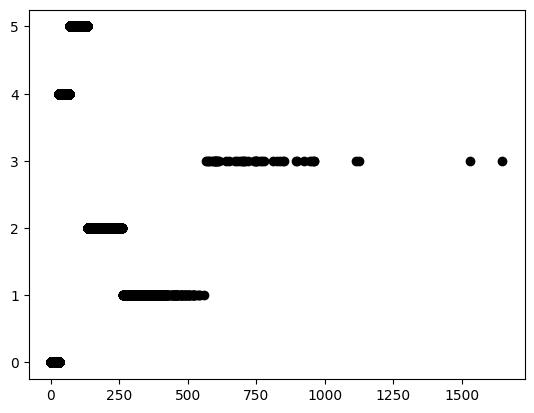

In [13]:
plt.scatter(df['QUANTITY'], df['Centrum'], color = 'k')
plt.show()